In [1]:
# Libraries

import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
# Create *known* parameters for synthetic data

weight = 0.7
bias = 0.3

# Create the data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

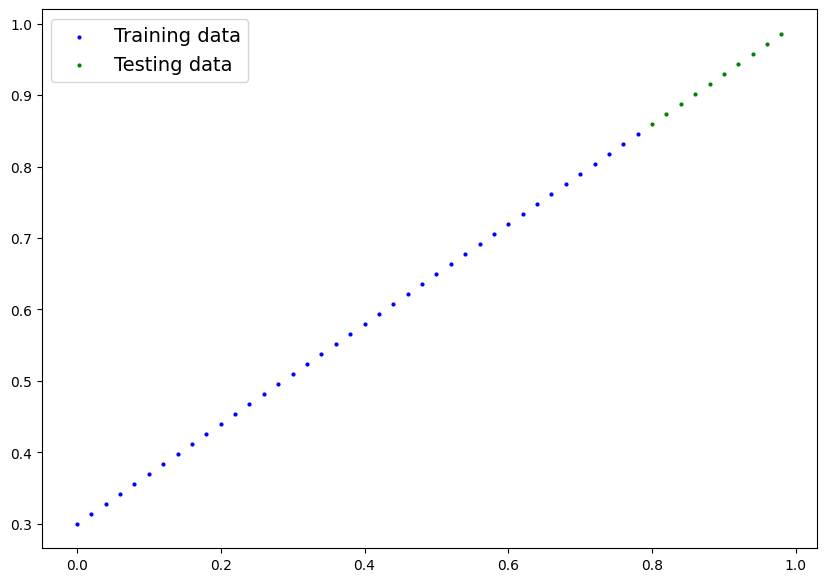

In [6]:
plot_predictions()

In [7]:
# Setting up ANN Architecture

class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Define 4 layers with increasing and then decreasing number of neurons
        self.layer1 = nn.Linear(in_features=1, out_features=8)
        self.layer2 = nn.Linear(in_features=8, out_features=1)

        # Define additional custom biases for each layer
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        
        # ReLU activation
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Pass data through each layer with ReLU in between and add custom biases
        x = self.relu(self.layer1(x))
        x = self.layer2(x) + self.bias
        return x


In [8]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = ANN()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.7489], requires_grad=True),
 Parameter containing:
 tensor([[ 0.7645],
         [ 0.8300],
         [-0.2343],
         [ 0.9186],
         [-0.2191],
         [ 0.2018],
         [-0.4869],
         [ 0.5873]], requires_grad=True),
 Parameter containing:
 tensor([ 0.8815, -0.7336,  0.8692,  0.1872,  0.7388,  0.1354,  0.4822, -0.1412],
        requires_grad=True),
 Parameter containing:
 tensor([[ 0.2725,  0.0523, -0.1651,  0.0901, -0.1629, -0.0415, -0.1436,  0.2345]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.2791], requires_grad=True)]

In [9]:
# List named parameters 
model_0.state_dict()

OrderedDict([('bias', tensor([0.7489])),
             ('layer1.weight', tensor([[ 0.7645],
                      [ 0.8300],
                      [-0.2343],
                      [ 0.9186],
                      [-0.2191],
                      [ 0.2018],
                      [-0.4869],
                      [ 0.5873]])),
             ('layer1.bias',
              tensor([ 0.8815, -0.7336,  0.8692,  0.1872,  0.7388,  0.1354,  0.4822, -0.1412])),
             ('layer2.weight',
              tensor([[ 0.2725,  0.0523, -0.1651,  0.0901, -0.1629, -0.0415, -0.1436,  0.2345]])),
             ('layer2.bias', tensor([-0.2791]))])

In [10]:
# Make predictions with model

with torch.inference_mode(): 
    y_preds = model_0(X_test)

In [11]:
# Check the predictions

print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.8070],
        [0.8183],
        [0.8296],
        [0.8409],
        [0.8522],
        [0.8642],
        [0.8764],
        [0.8885],
        [0.9007],
        [0.9129]])


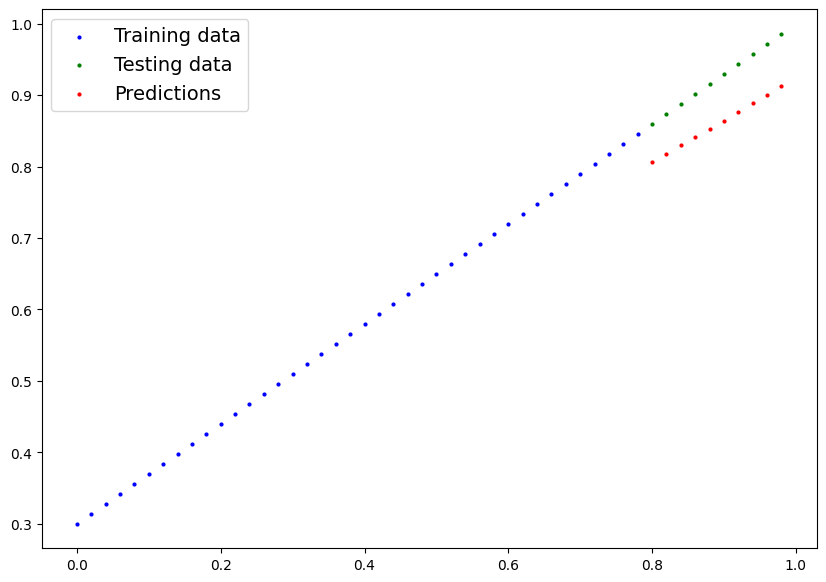

In [12]:
# Plotting predictions of untrained ANN

plot_predictions(predictions=y_preds) # These will be very wrong as the weights and biases are just random.

In [13]:
# Create the loss function

loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

In [14]:
# Create the optimizer

optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

In [15]:
# Training Loop

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 1000

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.032485492527484894 | MAE Test Loss: 0.062053509056568146 
Epoch: 10 | MAE Train Loss: 0.024001838639378548 | MAE Test Loss: 0.043189723044633865 
Epoch: 20 | MAE Train Loss: 0.015311574563384056 | MAE Test Loss: 0.023697977885603905 
Epoch: 30 | MAE Train Loss: 0.011595305055379868 | MAE Test Loss: 0.03450335934758186 
Epoch: 40 | MAE Train Loss: 0.010426675900816917 | MAE Test Loss: 0.043325264006853104 
Epoch: 50 | MAE Train Loss: 0.01231299713253975 | MAE Test Loss: 0.0556868240237236 
Epoch: 60 | MAE Train Loss: 0.01216790173202753 | MAE Test Loss: 0.055983059108257294 
Epoch: 70 | MAE Train Loss: 0.01202295534312725 | MAE Test Loss: 0.05627904459834099 
Epoch: 80 | MAE Train Loss: 0.011878186836838722 | MAE Test Loss: 0.0565747432410717 
Epoch: 90 | MAE Train Loss: 0.01173355057835579 | MAE Test Loss: 0.056870270520448685 
Epoch: 100 | MAE Train Loss: 0.011589091271162033 | MAE Test Loss: 0.05716855078935623 
Epoch: 110 | MAE Train Loss: 0.011444751173

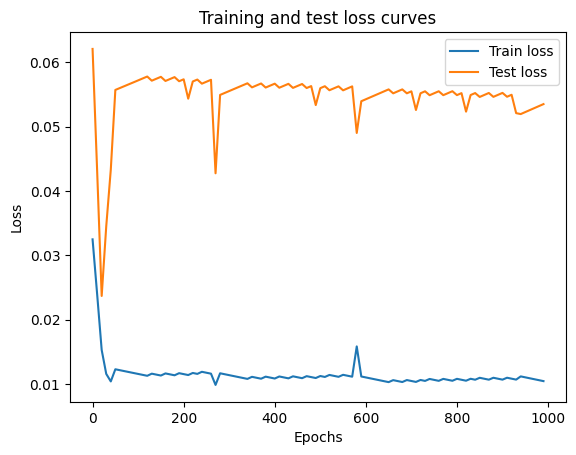

In [16]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [17]:
# Testing 

# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  model_0.to(device)
  X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[0.8607],
        [0.8744],
        [0.8882],
        [0.9019],
        [0.9156],
        [0.9301],
        [0.9447],
        [0.9589],
        [0.9717],
        [0.9846]], device='cuda:0')

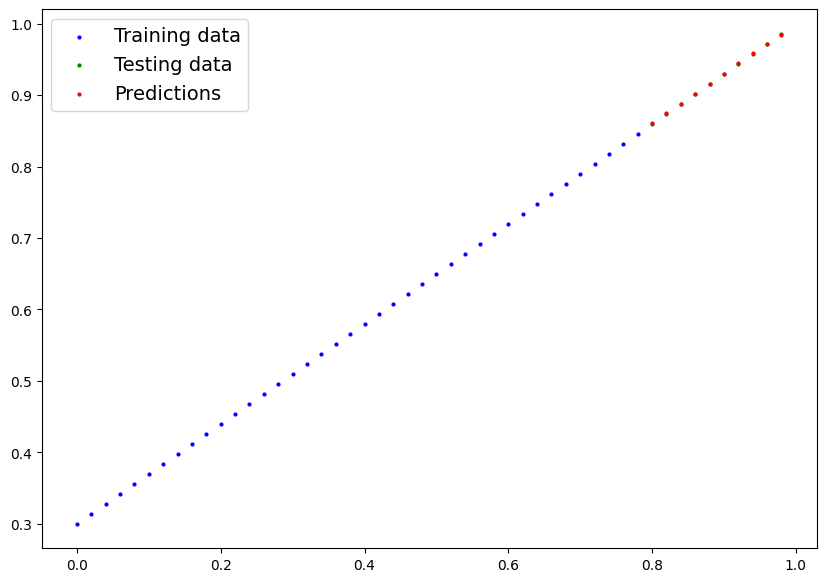

In [18]:
# Plotting predictions

plot_predictions(predictions=y_preds.cpu())